In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore') # Filter out warnings

---

In [2]:
# Training set with 1000 samples
df_train1000 = pd.read_excel('train_data.xlsx', sheet_name='Train 1000').drop(columns='Max_Thickness')
X_train1000 = df_train1000.loc[:, df_train1000.columns != 'CL']
y_train1000 = df_train1000[['CL']]

# Training set with 5000 samples
df_train5000 = pd.read_excel('train_data.xlsx', sheet_name='Train 5000').drop(columns='Max_Thickness')
X_train5000 = df_train5000.loc[:, df_train5000.columns != 'CL']
y_train5000 = df_train5000[['CL']]

# Training set with 10000 samples
df_train10000 = pd.read_excel('train_data.xlsx', sheet_name='Train 10000').drop(columns='Max_Thickness')
X_train10000 = df_train10000.loc[:, df_train10000.columns != 'CL']
y_train10000 = df_train10000[['CL']]

# Test set
df_test = pd.read_excel('test_data.xlsx').drop(columns='Max_Thickness')
X_test = df_test.loc[:, df_test.columns != 'CL']
y_test = df_test[['CL']]

#### 1.4 Normalize data 
Since the scale of the feature values vary significantly, I will normalize the data using `StandardScaler()` which transforms the data using $z = \dfrac{x - u}{s}$ where $u$ is the mean of the feature values, and $s$ is the standard deviation.

In [3]:
print("Preparing train/val sets...")

# create scaling object
X_scaler = StandardScaler()
X_train1000 = X_scaler.fit_transform(X_train1000)
X_train5000 = X_scaler.fit_transform(X_train5000)
X_train10000 = X_scaler.fit_transform(X_train10000)

X_test = X_scaler.fit_transform(X_test)
print(">> X_train and X_val normalized\n")

Preparing train/val sets...
>> X_train and X_val normalized



<a id="functions"></a>
### Part 3:

#### 3.1 Hyperparameter selection via cross-validation

In [4]:
def CV_with_GridSearch(estimator, h_parameters, cv, X_train, y_train):
    """
    Finds optimal hyperparameters for given model using GridSearchCV.
    
    Keyword arguments:
    estimator (sklearn model) -- instantiated ML model (e.g. SVC())
    h_parameters (list of dicts) -- hyperparameters to test
                                        e.g [{'multi_class': ['ovr'],
                                              'C': [0.01, 0.1, 1]},
    cv (int) -- number of folds to use in cross validation
    
    Returns:
    best_params (dict) -- most optimal parameters based on CV
    """
    clf = GridSearchCV(estimator, h_parameters, scoring='neg_mean_absolute_error', cv=3)
    clf.fit(X_train, y_train)
    
    best_params = clf.best_params_
    print("Best parameters set found on development set:\n")
    print(best_params)
    print("\nGrid scores on training set:\n")

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    return best_params

#### 3.2 Model creation and validation results

In [5]:
def estimate_model_results(final_estimator, X_train, y_train, X_test, y_test, bootstrap_results=False):
    """
    Calculates train/test accuracy and the test MAE's
    upper/lower bounds using bootstrapping.
    
    Keyword arguments:
    final_estimator (sklearn model) -- instantiated ML model (e.g. SVC())
    bootstrap_results (boolean) -- bootstraps validation accuracy results
    
    Returns:
    final_estimator (sklearn model) -- trained ML model
    MAE_test (float) -- test MAE
    MAE_bounds (list) -- confidence intervals for test MAE
    """
    # Fit model to training data
    final_estimator.fit(X_train, y_train)    
    
    # Predict response variable for both train and test sets
    y_train_pred = final_estimator.predict(X_train)
    y_test_pred = final_estimator.predict(X_test)
    
    # Calculate MSE on train and test sets
    MAE_train = mean_absolute_error(y_train, y_train_pred)
    MAE_test = mean_absolute_error(y_test, y_test_pred)  
    
    print(f'RESULTS\n\nModel: {final_estimator}:\n\nTraining set size: {len(X_train)} samples\n----')
    print('Train MAE:', MAE_train)
    print('Test MAE:', MAE_test)
    if bootstrap_results:
        MAE_bounds = bootstrap_metrics(1000, 0.95, final_estimator, X_test, y_test)
    else:
        MAE_bounds = 0
    return final_estimator, MAE_test, MAE_bounds


#### 3.3 Confidence intervals of test results using bootstrapping

In [6]:
def bootstrap_metrics(num_iterations, alpha, model, X_test, y_test):
    """
    Calculates upper/lower bounds of accuracy using bootstrapping
    
    Keyword arguments:
    num_iterations (int) -- number of times to run bootstrap
    alpha (float) -- confidence interval (e.g. 0.95 means "95% confidence")
    model (sklearn model) -- pre trained model ready to predict
    X_test (pandas dataframe or ndarray) -- Test data 
    y_test (pandas dataframe/series or ndarray) -- Test response variable
    
    Returns:
    acc_bounds (list) - accuracy CI bounds using bootstrapping
    """
    stat_MAE = []
    X_test = pd.DataFrame(X_test)
    y_test = pd.DataFrame(y_test).reset_index()[['CL']]
    test_set = X_test.join(y_test, how = "outer")

    for i in range(num_iterations):
        test_sample = resample(test_set, n_samples=len(test_set))
        X_sample = test_sample.loc[:, test_sample.columns != 'CL']
        y_sample = test_sample[['CL']]
    
        # Calculate MAE
        y_pred_sample = model.predict(X_sample) 
        MAE = mean_absolute_error(y_sample, y_pred_sample)
        
        # Store scores in list
        stat_MAE.append(MAE)
    
    q_lower = ((1-alpha)/2) * 100
    q_upper = (alpha + ((1-alpha)/2)) * 100
    
    # Accuracy bounds
    MAE_lower = max(0, np.percentile(stat_MAE, q_lower))
    MAE_upper = min(1, np.percentile(stat_MAE, q_upper))
    print('\n{}% Confidence interval for test MAE = [{} and {}]'.format(alpha*100, MAE_lower, MAE_upper))

    MAE_bounds = [MAE_lower, MAE_upper]

    # Plot results
    plot_bootstrap_results(stat_MAE, MAE_bounds)
    

    return MAE_bounds

In [7]:
def plot_bootstrap_results(statistic, bounds):
    """
    Calculates upper/lower bounds of accuracy using bootstrapping
    
    Keyword arguments:
    num_iterations (int) -- number of times to run bootstrap
    alpha (float) -- confidence interval (e.g. 0.95 means "95% confidence")
    model (sklearn model) -- pre trained model ready to predict
    X_val (pandas dataframe or ndarray) -- Validation data 
    y_val (pandas dataframe/series or ndarray) -- Validation classes
    
    Returns:
        None
    """
    plt.figure(figsize=(4,4))
    plt.hist(statistic)
    plt.axvline(x=bounds[0], color='r', linestyle='--')
    plt.axvline(x=bounds[1], color='r', linestyle='--')

    plt.title("Bootstrap CI for MAE", fontsize=12)
    plt.xlabel("MAE", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.show()

<a id="linreg"></a>
### Part 4: Linear regression 

#### 4.1 Training on 1000 samples

RESULTS

Model: LinearRegression():

Training set size: 1000 samples
----
Train MAE: 0.02597612632769578
Test MAE: 0.027164594122927873

95.0% Confidence interval for test MAE = [0.026587184643957658 and 0.02774016631451648]


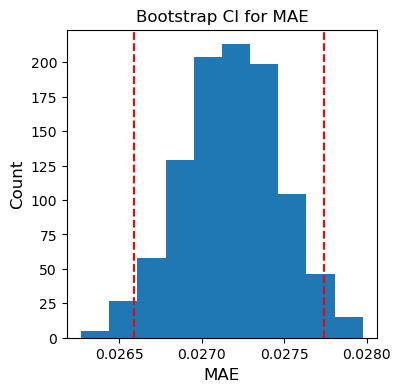

In [8]:
# Step 1
estimator = LinearRegression()

# Steps 2-4 not relevant

# Step 5
linear_model, MAE_test_linear, CI_ridge = estimate_model_results(
    estimator, X_train1000, y_train1000, X_test, y_test, bootstrap_results=True)

#### 4.2 Training on 5000 samples

RESULTS

Model: LinearRegression():

Training set size: 5000 samples
----
Train MAE: 0.02674247718880032
Test MAE: 0.027201848001456228

95.0% Confidence interval for test MAE = [0.02664870152786263 and 0.027789257490193852]


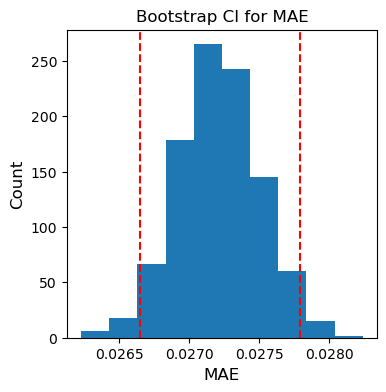

In [9]:
linear_model, MAE_test_linear, CI_ridge = estimate_model_results(
    estimator, X_train5000, y_train5000, X_test, y_test, bootstrap_results=True)

#### 4.3 Training on 10000 samples

RESULTS

Model: LinearRegression():

Training set size: 10000 samples
----
Train MAE: 0.02682438628556822
Test MAE: 0.026945651653536146

95.0% Confidence interval for test MAE = [0.0263711142421405 and 0.02750597326339394]


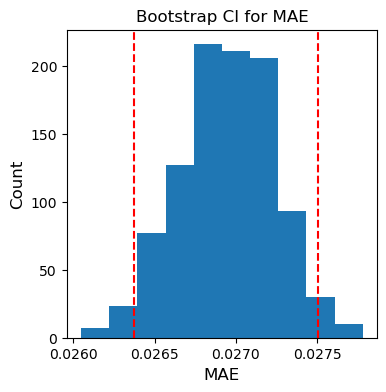

In [10]:
linear_model, MAE_test_linear, CI_ridge = estimate_model_results(
    estimator, X_train10000, y_train10000, X_test, y_test, bootstrap_results=True)

<a id="ridge"></a>
### Part 5: Ridge regression 

#### 5.1 Training on 1000 samples

In [11]:
# Step 1
estimator = Ridge()

# Step 2
h_parameters = [{'alpha': [np.exp(i) for i in range(-4,6)]}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train1000, y_train1000)

Best parameters set found on development set:

{'alpha': 2.718281828459045}

Grid scores on training set:

-0.026 (+/-0.002) for {'alpha': 0.01831563888873418}
-0.026 (+/-0.002) for {'alpha': 0.049787068367863944}
-0.026 (+/-0.002) for {'alpha': 0.1353352832366127}
-0.026 (+/-0.002) for {'alpha': 0.36787944117144233}
-0.026 (+/-0.002) for {'alpha': 1.0}
-0.026 (+/-0.002) for {'alpha': 2.718281828459045}
-0.026 (+/-0.001) for {'alpha': 7.38905609893065}
-0.026 (+/-0.001) for {'alpha': 20.085536923187668}
-0.029 (+/-0.001) for {'alpha': 54.598150033144236}
-0.040 (+/-0.002) for {'alpha': 148.4131591025766}


RESULTS

Model: Ridge(alpha=2.718281828459045):

Training set size: 1000 samples
----
Train MAE: 0.025968201023253208
Test MAE: 0.027175786685305355

95.0% Confidence interval for test MAE = [0.02662879976221649 and 0.027801428708795806]


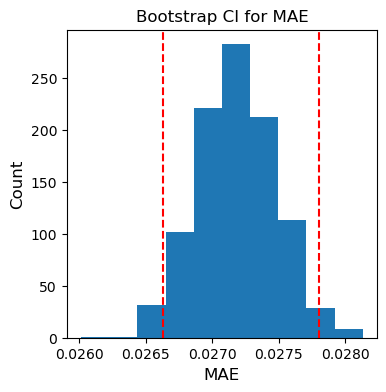

In [12]:
# Step 4
ridge_model = Ridge(alpha= best_params['alpha'])

# Step 5
ridge_model, MAE_test_ridge, CI_ridge = estimate_model_results(
    ridge_model, X_train1000, y_train1000, X_test, y_test, bootstrap_results=True)

#### 5.1 Training on 5000 samples

In [13]:
# Step 1
estimator = Ridge()

# Step 2
h_parameters = [{'alpha': [np.exp(i) for i in range(-4,8)]}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train5000, y_train5000)

Best parameters set found on development set:

{'alpha': 7.38905609893065}

Grid scores on training set:

-0.027 (+/-0.000) for {'alpha': 0.01831563888873418}
-0.027 (+/-0.000) for {'alpha': 0.049787068367863944}
-0.027 (+/-0.000) for {'alpha': 0.1353352832366127}
-0.027 (+/-0.000) for {'alpha': 0.36787944117144233}
-0.027 (+/-0.000) for {'alpha': 1.0}
-0.027 (+/-0.000) for {'alpha': 2.718281828459045}
-0.027 (+/-0.000) for {'alpha': 7.38905609893065}
-0.027 (+/-0.000) for {'alpha': 20.085536923187668}
-0.027 (+/-0.000) for {'alpha': 54.598150033144236}
-0.027 (+/-0.000) for {'alpha': 148.4131591025766}
-0.031 (+/-0.001) for {'alpha': 403.4287934927351}
-0.047 (+/-0.002) for {'alpha': 1096.6331584284585}


RESULTS

Model: Ridge(alpha=7.38905609893065):

Training set size: 5000 samples
----
Train MAE: 0.026740596701457047
Test MAE: 0.027213127402730186

95.0% Confidence interval for test MAE = [0.026594252142054884 and 0.027807463308457136]


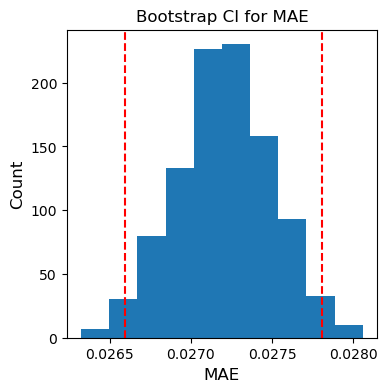

In [14]:
# Step 4
ridge_model = Ridge(alpha= best_params['alpha'])

# Step 5
ridge_model, MAE_test_ridge, CI_ridge = estimate_model_results(
    ridge_model, X_train5000, y_train5000, X_test, y_test, bootstrap_results=True)

#### 5.1 Training on 10000 samples

In [15]:
# Step 1
estimator = Ridge()

# Step 2
h_parameters = [{'alpha': [np.exp(i) for i in range(-4,8)]}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train10000, y_train10000)

Best parameters set found on development set:

{'alpha': 20.085536923187668}

Grid scores on training set:

-0.027 (+/-0.001) for {'alpha': 0.01831563888873418}
-0.027 (+/-0.001) for {'alpha': 0.049787068367863944}
-0.027 (+/-0.001) for {'alpha': 0.1353352832366127}
-0.027 (+/-0.001) for {'alpha': 0.36787944117144233}
-0.027 (+/-0.001) for {'alpha': 1.0}
-0.027 (+/-0.001) for {'alpha': 2.718281828459045}
-0.027 (+/-0.001) for {'alpha': 7.38905609893065}
-0.027 (+/-0.001) for {'alpha': 20.085536923187668}
-0.027 (+/-0.001) for {'alpha': 54.598150033144236}
-0.027 (+/-0.001) for {'alpha': 148.4131591025766}
-0.028 (+/-0.001) for {'alpha': 403.4287934927351}
-0.034 (+/-0.001) for {'alpha': 1096.6331584284585}


RESULTS

Model: Ridge(alpha=20.085536923187668):

Training set size: 10000 samples
----
Train MAE: 0.02681912847530467
Test MAE: 0.026952217479798764

95.0% Confidence interval for test MAE = [0.026354716687499412 and 0.02753733189039423]


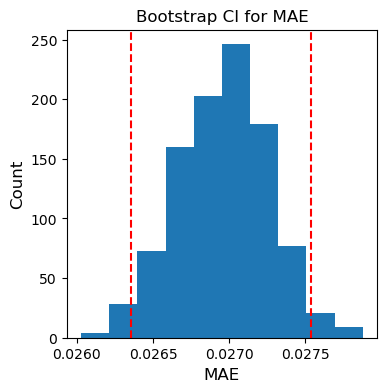

In [16]:
# Step 4
ridge_model = Ridge(alpha= best_params['alpha'])

# Step 5
ridge_model, MAE_test_ridge, CI_ridge = estimate_model_results(
    ridge_model, X_train10000, y_train10000, X_test, y_test, bootstrap_results=True)

<a id="lasso"></a>
### Part 6: Lasso regression 

#### 6.1 Training on 1000 samples

In [17]:
# Step 1
estimator = Lasso()

# Step 2
h_parameters = [{'alpha': [np.exp(i) for i in range(-8,0)]}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train1000, y_train1000)

Best parameters set found on development set:

{'alpha': 0.00033546262790251185}

Grid scores on training set:

-0.026 (+/-0.002) for {'alpha': 0.00033546262790251185}
-0.026 (+/-0.002) for {'alpha': 0.0009118819655545162}
-0.026 (+/-0.002) for {'alpha': 0.0024787521766663585}
-0.028 (+/-0.002) for {'alpha': 0.006737946999085467}
-0.038 (+/-0.002) for {'alpha': 0.01831563888873418}
-0.057 (+/-0.002) for {'alpha': 0.049787068367863944}
-0.125 (+/-0.003) for {'alpha': 0.1353352832366127}
-0.156 (+/-0.003) for {'alpha': 0.36787944117144233}


RESULTS

Model: Lasso(alpha=0.00033546262790251185):

Training set size: 1000 samples
----
Train MAE: 0.02594471566024159
Test MAE: 0.027129337666713552

95.0% Confidence interval for test MAE = [0.026558692474891742 and 0.027728071360277502]


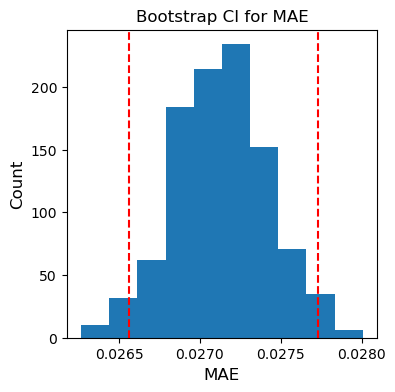

In [18]:
# Step 4
lasso_model = Lasso(alpha= best_params['alpha'])

# Step 5
lasso_model, MAE_test_lasso, CI_lasso = estimate_model_results(
    lasso_model, X_train1000, y_train1000, X_test, y_test, bootstrap_results=True)

#### 6.2 Training on 5000 samples

In [19]:
# Step 1
estimator = Lasso()

# Step 2
h_parameters = [{'alpha': [np.exp(i) for i in range(-8,0)]}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train5000, y_train5000)

Best parameters set found on development set:

{'alpha': 0.0009118819655545162}

Grid scores on training set:

-0.027 (+/-0.000) for {'alpha': 0.00033546262790251185}
-0.027 (+/-0.000) for {'alpha': 0.0009118819655545162}
-0.027 (+/-0.000) for {'alpha': 0.0024787521766663585}
-0.028 (+/-0.001) for {'alpha': 0.006737946999085467}
-0.038 (+/-0.002) for {'alpha': 0.01831563888873418}
-0.056 (+/-0.003) for {'alpha': 0.049787068367863944}
-0.123 (+/-0.003) for {'alpha': 0.1353352832366127}
-0.155 (+/-0.002) for {'alpha': 0.36787944117144233}


RESULTS

Model: Lasso(alpha=0.0009118819655545162):

Training set size: 5000 samples
----
Train MAE: 0.026682431325179994
Test MAE: 0.02720101488946406

95.0% Confidence interval for test MAE = [0.02660059381308214 and 0.027771341640163167]


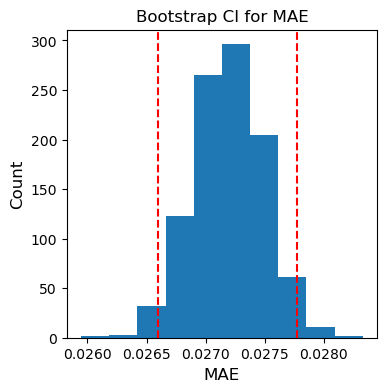

In [20]:
# Step 4
lasso_model = Lasso(alpha= best_params['alpha'])

# Step 5
lasso_model, MAE_test_lasso, CI_lasso = estimate_model_results(
    lasso_model, X_train5000, y_train5000, X_test, y_test, bootstrap_results=True)

#### 6.3 Training on 5000 samples

In [21]:
# Step 1
estimator = Lasso()

# Step 2
h_parameters = [{'alpha': [np.exp(i) for i in range(-8,0)]}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train10000, y_train10000)

Best parameters set found on development set:

{'alpha': 0.0009118819655545162}

Grid scores on training set:

-0.027 (+/-0.001) for {'alpha': 0.00033546262790251185}
-0.027 (+/-0.001) for {'alpha': 0.0009118819655545162}
-0.027 (+/-0.001) for {'alpha': 0.0024787521766663585}
-0.028 (+/-0.001) for {'alpha': 0.006737946999085467}
-0.038 (+/-0.002) for {'alpha': 0.01831563888873418}
-0.056 (+/-0.003) for {'alpha': 0.049787068367863944}
-0.123 (+/-0.006) for {'alpha': 0.1353352832366127}
-0.155 (+/-0.004) for {'alpha': 0.36787944117144233}


RESULTS

Model: Lasso(alpha=0.0009118819655545162):

Training set size: 5000 samples
----
Train MAE: 0.026682431325179994
Test MAE: 0.02720101488946406

95.0% Confidence interval for test MAE = [0.026660664395560373 and 0.02779512944917976]


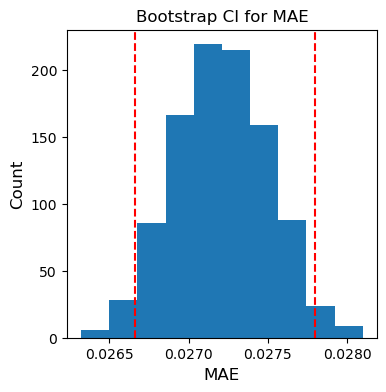

In [22]:
# Step 4
lasso_model = Lasso(alpha= best_params['alpha'])

# Step 5
lasso_model, MAE_test_lasso, CI_lasso = estimate_model_results(
    lasso_model, X_train5000, y_train5000, X_test, y_test, bootstrap_results=True)

<a id="RF"></a>
### Part 7: Random Forest

#### 7.1 Training on 1000 samples

In [23]:
# Step 1
estimator = RandomForestRegressor(n_estimators=100, random_state=10)

# Step 2
h_parameters = [{'max_features': range(1,5)}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train1000, y_train1000)

Best parameters set found on development set:

{'max_features': 4}

Grid scores on training set:

-0.054 (+/-0.014) for {'max_features': 1}
-0.033 (+/-0.010) for {'max_features': 2}
-0.025 (+/-0.009) for {'max_features': 3}
-0.022 (+/-0.007) for {'max_features': 4}


In [24]:
# Step 4
RF = RandomForestRegressor(n_estimators=500, random_state=10, max_features=5)

# Step 5
RF_model, MAE_test_RF, CI_RF = estimate_model_results(
    RF, X_train1000, y_train1000, X_test, y_test, bootstrap_results=False)

RESULTS

Model: RandomForestRegressor(max_features=5, n_estimators=500, random_state=10):

Training set size: 1000 samples
----
Train MAE: 0.006070839999999961
Test MAE: 0.01712489599999999


#### 7.2 Training on 5000 samples

In [25]:
# Step 1
estimator = RandomForestRegressor(n_estimators=100, random_state=10)

# Step 2
h_parameters = [{'max_features': range(1,5)}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train5000, y_train5000)

Best parameters set found on development set:

{'max_features': 4}

Grid scores on training set:

-0.040 (+/-0.016) for {'max_features': 1}
-0.025 (+/-0.012) for {'max_features': 2}
-0.017 (+/-0.008) for {'max_features': 3}
-0.014 (+/-0.004) for {'max_features': 4}


In [26]:
# Step 4
RF = RandomForestRegressor(n_estimators=500, random_state=10, max_features=4)

# Step 5
RF_model, MAE_test_RF, CI_RF = estimate_model_results(
    RF, X_train5000, y_train5000, X_test, y_test, bootstrap_results=False)

RESULTS

Model: RandomForestRegressor(max_features=4, n_estimators=500, random_state=10):

Training set size: 5000 samples
----
Train MAE: 0.003812295999999955
Test MAE: 0.011164759999999942


#### 7.3 Training on 10000 samples

In [27]:
# Step 1
estimator = RandomForestRegressor(n_estimators=100, random_state=10)

# Step 2
h_parameters = [{'max_features': range(1,5)}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train10000, y_train10000)

Best parameters set found on development set:

{'max_features': 4}

Grid scores on training set:

-0.036 (+/-0.016) for {'max_features': 1}
-0.021 (+/-0.012) for {'max_features': 2}
-0.014 (+/-0.006) for {'max_features': 3}
-0.012 (+/-0.005) for {'max_features': 4}


In [28]:
# Step 4
RF = RandomForestRegressor(n_estimators=500, random_state=10, max_features=4)

# Step 5
RF_model, MAE_test_RF, CI_RF = estimate_model_results(
    RF, X_train10000, y_train10000, X_test, y_test, bootstrap_results=False)

RESULTS

Model: RandomForestRegressor(max_features=4, n_estimators=500, random_state=10):

Training set size: 10000 samples
----
Train MAE: 0.0030970319999999614
Test MAE: 0.008903431999999926


<a id="CART"></a>
### Part 8: Decision Tree

#### 8.1 Training on 1000 samples

In [29]:
# Step 1
estimator = DecisionTreeRegressor(min_samples_leaf=5, random_state=10)

# Step 2
h_parameters = [{'min_impurity_decrease': np.linspace(0,0.01, 11)}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train1000, y_train1000)

Best parameters set found on development set:

{'min_impurity_decrease': 0.0}

Grid scores on training set:

-0.024 (+/-0.003) for {'min_impurity_decrease': 0.0}
-0.050 (+/-0.003) for {'min_impurity_decrease': 0.001}
-0.050 (+/-0.003) for {'min_impurity_decrease': 0.002}
-0.074 (+/-0.019) for {'min_impurity_decrease': 0.003}
-0.080 (+/-0.002) for {'min_impurity_decrease': 0.004}
-0.080 (+/-0.002) for {'min_impurity_decrease': 0.005}
-0.080 (+/-0.002) for {'min_impurity_decrease': 0.006}
-0.080 (+/-0.002) for {'min_impurity_decrease': 0.007}
-0.080 (+/-0.002) for {'min_impurity_decrease': 0.008}
-0.080 (+/-0.002) for {'min_impurity_decrease': 0.009000000000000001}
-0.080 (+/-0.002) for {'min_impurity_decrease': 0.01}


In [30]:
# Step 4
CART_model = DecisionTreeRegressor(min_samples_leaf=5, random_state=10)

# Step 5
CART_model, MAE_test_CART, CI_CART = estimate_model_results(
    CART_model, X_train1000, y_train1000, X_test, y_test, bootstrap_results=False)

RESULTS

Model: DecisionTreeRegressor(min_samples_leaf=5, random_state=10):

Training set size: 1000 samples
----
Train MAE: 0.012568650793650793
Test MAE: 0.02204824126984127


#### 8.2 Training on 5000 samples

In [31]:
# Step 1
estimator = DecisionTreeRegressor(min_samples_leaf=5, random_state=10)

# Step 2
h_parameters = [{'min_impurity_decrease': np.linspace(0,0.01, 11)}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train5000, y_train5000)

Best parameters set found on development set:

{'min_impurity_decrease': 0.0}

Grid scores on training set:

-0.016 (+/-0.000) for {'min_impurity_decrease': 0.0}
-0.050 (+/-0.001) for {'min_impurity_decrease': 0.001}
-0.050 (+/-0.001) for {'min_impurity_decrease': 0.002}
-0.069 (+/-0.017) for {'min_impurity_decrease': 0.003}
-0.082 (+/-0.002) for {'min_impurity_decrease': 0.004}
-0.082 (+/-0.002) for {'min_impurity_decrease': 0.005}
-0.082 (+/-0.002) for {'min_impurity_decrease': 0.006}
-0.082 (+/-0.002) for {'min_impurity_decrease': 0.007}
-0.082 (+/-0.002) for {'min_impurity_decrease': 0.008}
-0.082 (+/-0.002) for {'min_impurity_decrease': 0.009000000000000001}
-0.082 (+/-0.002) for {'min_impurity_decrease': 0.01}


In [32]:
# Step 4
CART_model = DecisionTreeRegressor(min_samples_leaf=5, random_state=10)

# Step 5
CART_model, MAE_test_CART, CI_CART = estimate_model_results(
    CART_model, X_train5000, y_train5000, X_test, y_test, bootstrap_results=False)

RESULTS

Model: DecisionTreeRegressor(min_samples_leaf=5, random_state=10):

Training set size: 5000 samples
----
Train MAE: 0.00841017460317461
Test MAE: 0.014643631746031753


#### 8.3 Training on 10000 samples

In [33]:
# Step 1
estimator = DecisionTreeRegressor(min_samples_leaf=5, random_state=10)

# Step 2
h_parameters = [{'min_impurity_decrease': np.linspace(0,0.01, 11)}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train10000, y_train10000)

Best parameters set found on development set:

{'min_impurity_decrease': 0.0}

Grid scores on training set:

-0.013 (+/-0.000) for {'min_impurity_decrease': 0.0}
-0.049 (+/-0.001) for {'min_impurity_decrease': 0.001}
-0.049 (+/-0.001) for {'min_impurity_decrease': 0.002}
-0.081 (+/-0.000) for {'min_impurity_decrease': 0.003}
-0.081 (+/-0.000) for {'min_impurity_decrease': 0.004}
-0.081 (+/-0.000) for {'min_impurity_decrease': 0.005}
-0.081 (+/-0.000) for {'min_impurity_decrease': 0.006}
-0.081 (+/-0.000) for {'min_impurity_decrease': 0.007}
-0.081 (+/-0.000) for {'min_impurity_decrease': 0.008}
-0.081 (+/-0.000) for {'min_impurity_decrease': 0.009000000000000001}
-0.081 (+/-0.000) for {'min_impurity_decrease': 0.01}


In [34]:
# Step 4
CART_model = DecisionTreeRegressor(random_state=10)

# Step 5
CART_model, MAE_test_CART, CI_CART = estimate_model_results(
    CART_model, X_train10000, y_train10000, X_test, y_test, bootstrap_results=False)

RESULTS

Model: DecisionTreeRegressor(random_state=10):

Training set size: 10000 samples
----
Train MAE: 1.890015921546251e-17
Test MAE: 0.011816000000000014
